# Demonstration of Interatomic Potential Testing Framework

**James Kermode**
<br>
March 2021

Data and code available from https://github.com/libAtoms/testing-framework


In [12]:
import numpy
import numpy as np
#from analyze_utils import *
import matplotlib
matplotlib.use('PDF')
from matplotlib import pyplot

import phonopy
import ase.units

ModuleNotFoundError: No module named 'analyze_utils'

In [13]:
import itertools
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nglview

from ase.io import read

sns.set_context('talk')

os.chdir(os.path.expanduser('../example_models/Si/run_dir'))
! [[ ! -d ../tests ]] && ln -s ~/tests/Si ../tests

FileNotFoundError: [Errno 2] No such file or directory: '../example_models/Si/run_dir'

## Energy-Volume curves

We can read in the existing data:

In [6]:
def read_data(model_names):
    data = {}
    for model_name in model_names:
        json_file = f"Si-model-{model_name}-test-bulk_Si_diamond-properties.json"
        model_name = os.path.basename(json_file).split('-')[2]
        data[model_name] = json.load(open(json_file))
    return data
    
data = read_data(['CASTEP_ASE', 'GAP'])
ref_model_name = 'CASTEP_ASE'

In [7]:
data

{'CASTEP_ASE': {'B': 88.5966966666666,
  'c12': 56.25008999999995,
  'c11': 153.28990999999988,
  'E_vs_V': [[17.813109023568057, -163.06663280425],
   [18.322054995670012, -163.110046112],
   [18.83100096777195, -163.1415028745],
   [19.33994693987392, -163.162464704125],
   [19.848892911975845, -163.174242557],
   [20.3578388840778, -163.177966801875],
   [20.86678485617974, -163.17463056225],
   [21.375730828281693, -163.165132595375],
   [21.884676800383637, -163.150242437875],
   [22.39362277248558, -163.130671150875],
   [22.902568744587512, -163.107009425875],
   [23.411514716689464, -163.079814823625]],
  'c44': 72.17693,
  'a0': 5.4610215037046075},
 'GAP': {'B': 88.8102174399424,
  'c12': 57.523403533287755,
  'c11': 151.3838452532517,
  'E_vs_V': [[17.810988598616127, -163.0664086908508],
   [18.319873987148007, -163.10988532610546],
   [18.82875937567989, -163.14135897170343],
   [19.337644764211802, -163.1623186809442],
   [19.846530152743675, -163.17407908173888],
   [20.

Now we define some simple functions to plot energy volume curves for the reference DFT and GAP models. Here we fit a quartic polynomial to the data.

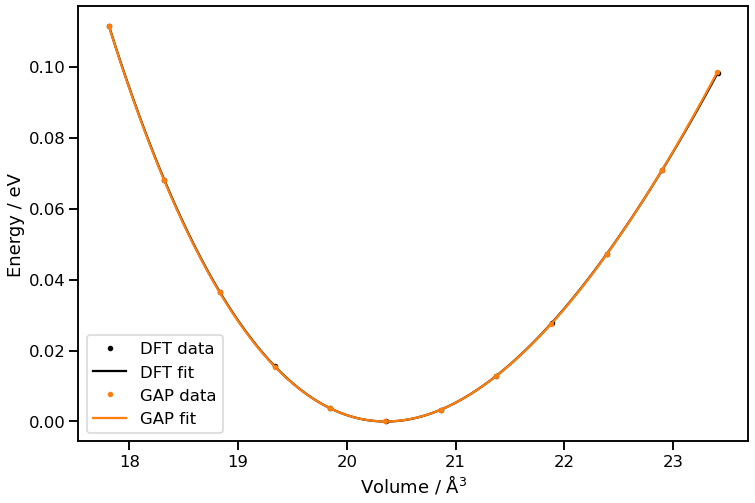

In [8]:
def polyplot(ax, V, E, color, label):
    p = np.polyfit(V, E - E.min(), 4)
    v = np.linspace(V.min(), V.max(), 100)
    e = np.polyval(p, v)
    ax.plot(V, E - E.min(), color+'.', label=label+' data')
    ax.plot(v, e, color+'-', label=label+' fit')

def plot_e_vs_v(all_data, ref_model_name, colors=None):
    ref_data = all_data[ref_model_name]
    ref_E_vs_V = np.array(ref_data['E_vs_V'])
    fig, ax = plt.subplots(figsize=(12,8))
    polyplot(ax, ref_E_vs_V[:,0], ref_E_vs_V[:,1], 'k', 'DFT')
    
    if colors is None:
        colors = itertools.cycle(['C0', 'C1', 'C2', 'C3', 'C4'])

    for model_name, color in zip(all_data, colors):
        if model_name == ref_model_name:
            continue
        data = all_data[model_name]
        E_vs_V = np.array(data['E_vs_V'], dtype=object)
        V = E_vs_V[:, 0].astype(float)
        E = E_vs_V[:, 1].astype(float)
        polyplot(ax, V, E - E.min(), color, model_name)        
        

    ax.set_xlabel(r'Volume / $\mathrm{\AA}^3$')
    ax.set_ylabel('Energy / eV')
    plt.legend()
    
plot_e_vs_v(data, ref_model_name)

## Bulk Properties

As well as the energy volume curve, the bulk test computes a number of other bulk properties, which we can tabulate:

In [85]:
df = pd.DataFrame(data)
df.drop('E_vs_V')

,CASTEP_ASE,GAP
B,88.596697,88.810217
c12,56.25009,57.523404
c11,153.28991,151.383845
c44,72.17693,67.863739
a0,5.461022,5.460805


## Adding a new model

Let's define a model for the screened Tersoff potential as implemented in `atomistica`. This is as simple as creating a `model.py` file in the `models/TersoffScr` directory.

In [54]:
![[ ! -d ../models/TersoffScr ]] && mkdir ../models/TersoffScr

with open("../models/TersoffScr/model.py", "w") as f:
    f.write("""
from atomistica import TersoffScr

calculator = TersoffScr()
name = 'TersoffScr'
no_checkpoint = True
""")

## Rerunning a single test with the new model

We can rerun an individual test with the `run-model-test.py` script: this takes the name of the model and of the test as arugments, and usually captures the output to a logfile. The `-l` option gives a label for the set of calculations; here we use `"Si"` to match with what was done for the GAP and DFT tests.

In [111]:
 !python ../../../scripts/run-model-test.py -l Si TersoffScr bulk_Si_diamond

share_dir /home/jovyan/scripts/../share


If we try to run the test again, it notices the `.json` file is present and avoids rerunning - this time we add the `-N` option to turn off capturing of stdout so we can see it directly in the notebook:

In [112]:
 !python ../../../scripts/run-model-test.py -N -l Si TersoffScr bulk_Si_diamond

share_dir /home/jovyan/scripts/../share
../Si-model-TersoffScr-test-bulk_Si_diamond-properties.json already exists and is not empty, not rerunning test


## Repeating the postprocessing analysis

Now we can go back and add the `TersoffScr` results to our energy-volume plot and data table:

,CASTEP_ASE,GAP,TersoffScr
B,88.596697,88.810217,96.897975
c12,56.25009,57.523404,74.571981
c11,153.28991,151.383845,141.549961
c44,72.17693,67.863739,68.82712
a0,5.461022,5.460805,NaN


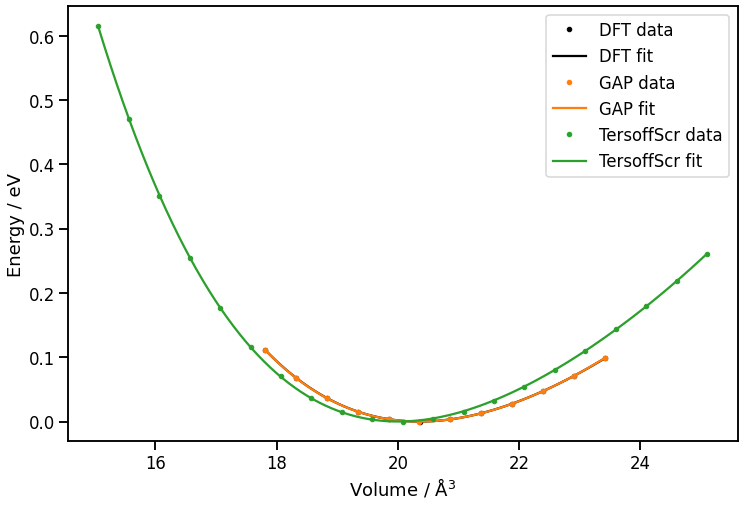

In [129]:
data = read_data(['CASTEP_ASE', 'GAP', 'TersoffScr'])
plot_e_vs_v(data, ref_model_name)

display(pd.DataFrame(data).drop('E_vs_V'))

The `NaN` for **a0** indicates missing data, not a failure with the test: the `bulk_Si_diamond` test no longer stores the lattice constant, but instead saves the full relaxed cell, which we can read in and visualise:

In [128]:
atoms = read('Si-model-TersoffScr-test-bulk_Si_diamond-relaxed.xyz')
v = nglview.show_ase(atoms * 3, cell=True)
v.add_unitcell()
v

NGLWidget()

We can update our data table accordingly:

In [136]:
data['TersoffScr']['a0'] = atoms.cell[0, 0] * 2.0
display(pd.DataFrame(data).drop('E_vs_V'))

,CASTEP_ASE,GAP,TersoffScr
B,88.596697,88.810217,96.897975
c12,56.25009,57.523404,74.571981
c11,153.28991,151.383845,141.549961
c44,72.17693,67.863739,68.82712
a0,5.461022,5.460805,5.436147


## Running all model/test pairs

To fill in results for missing model/test pairs, we could use the `run-all.py` script. By default this would run all pairs, but here we restrict to our new model to fill in the remainder of the tests with the `TersoffScr` potential.

This takes a few minutes to complete.

In [59]:
 !python ../../../scripts/run-all.py -s Si --models TersoffScr

Models asked for:  ['TersoffScr']
Models path:  /home/jovyan/example_models/Si/run_dir/../models
Models found:  ['/home/jovyan/example_models/Si/run_dir/../models/TersoffScr/model.py']
Models: ['/home/jovyan/example_models/Si/run_dir/../models/TersoffScr']
Tests: [('/home/jovyan/scripts/../tests/Si/qha_diamond', 'Si'), ('/home/jovyan/scripts/../tests/Si/bulk_Si_simple_hexagonal', 'Si'), ('/home/jovyan/scripts/../tests/Si/surface-decohesion-111-unrelaxed', 'Si'), ('/home/jovyan/scripts/../tests/Si/bulk_Si_bc8', 'Si'), ('/home/jovyan/scripts/../tests/Si/bulk_Si_hcp', 'Si'), ('/home/jovyan/scripts/../tests/Si/surface-decohesion-110-unrelaxed', 'Si'), ('/home/jovyan/scripts/../tests/Si/phonon_bulks', 'Si'), ('/home/jovyan/scripts/../tests/Si/bulk_Si_fcc', 'Si'), ('/home/jovyan/scripts/../tests/Si/bulk_Si_hexagonal_diamond', 'Si'), ('/home/jovyan/scripts/../tests/Si/surface-decohesion-100-unrelaxed', 'Si'), ('/home/jovyan/scripts/../tests/Si/bulk_Si_hcp_sf', 'Si'), ('/home/jovyan/scripts/..